In [1]:
# Makes the display take up more of the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [21]:
# export
import os
import torch as T
import numpy as np
import pandas as pd


In [56]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
# export
def set_seed(x):
    np.random.seed(x)
    T.manual_seed(x)
    T.backends.cudnn.deterministic = True
    T.backends.cudnn.benchmark  = False
    if T.cuda.is_available(): T.cuda.manual_seed_all(x)

In [6]:
set_seed(42)

In [7]:
# export 
def byte2np_RGB(response, Save=False, path='data', filename='Test'):
    img1d = np.fromstring(response.image_data_uint8, dtype=np.uint8)
    # reshape array to 4 channel image array H X W X 4
    img_rgb = img1d.reshape(3, response.height, response.width)
    if Save: 
        filename = os.path.join(path, filename)
        np.save(filename, img_rgb)
    return img_rgb

In [ ]:
# export 
def byte2np_Depth(response, Save=False, path='data', filename='Test'):
    img1d = np.array(response.image_data_float, dtype=np.float)
    img1d = img1d * 3.5 + 30
    img1d[img1d > 255] = 255
    depth = np.reshape(img1d, (response.height, response.width))
    if Save: 
        filename = os.path.join(path, filename)
        np.save(filename, depth)
    return depth

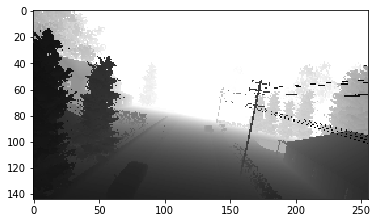

In [60]:
depth=np.load('data/Front_center_DepthPlanar.npy')
plt.imshow(depth, interpolation='nearest', cmap='gray')
plt.show()

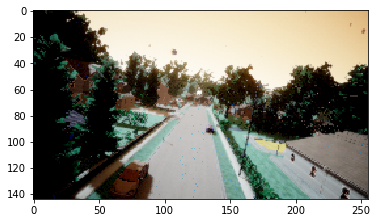

In [75]:
img=np.load('data/Front_center_RGB.npy')
img=img.reshape(img.shape[1], img.shape[2],3)

plt.imshow(img, interpolation='nearest')
plt.show()

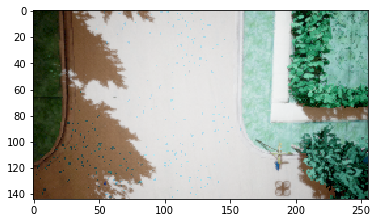

In [72]:
img=np.load('data/Bottom_center_RGB.npy')
img=img.reshape(img.shape[1], img.shape[2],3)
plt.imshow(img, interpolation='nearest')
plt.show()

In [71]:
# this is the print statement from self.client.getGpsData():
'''<GpsData> {   'gnss': <GnssReport> {   'eph': 0.3000044822692871,
    'epv': 0.40000447630882263,
    'fix_type': 3,
    'geo_point': <GeoPoint> {   'altitude': 132.32289123535156,
    'latitude': 47.6416150728889,
    'longitude': -122.14040436968116},
    'time_utc': 1645971445395087,
    'velocity': <Vector3r> {   'x_val': -0.24463589489459991,
    'y_val': 0.05023214593529701,
    'z_val': -0.6591682434082031}},
    'is_valid': True,
    'time_stamp': 1645971445395087360} <Vector3r> {   'x_val': 14.724202156066895,
    'y_val': -2.943709135055542,
    'z_val': -9.155741691589355}
'''

In [30]:
# export
class GPShistory:
    def __init__(self, position, velocity, reward, time_stamp):
        self.columns=['x_position', 'x_position', 'z_position',
                     'x_velocity', 'y_velocity', 'z_velocity', 
                     'Reward', 'time_stamp']
        
        self.df=pd.DataFrame([[position.x_val, position.y_val, position.z_val,
                               velocity.x_val, velocity.y_val, velocity.z_val,
                              reward, time_stamp]], columns=self.columns)
        
    def appendGPShistory(self, position, velocity, reward, time_stamp):
        self.df.loc[len(self.df)]= [position.x_val, position.y_val, position.z_val,
                                    velocity.x_val, velocity.y_val, velocity.z_val,
                                    reward, time_stamp]
        
    def saveGPS2csv(self, filename):
        self.df.to_csv(filename, index=False)

In [82]:
# test data
import time

position={   'x_val': 14.724202156066895,
    'y_val': -2.943709135055542,
    'z_val': -9.155741691589355}
velocity={   'x_val': 1.724202156066895,
    'y_val': -2.542,
    'z_val': -1.55}


time_stamp=time.time_ns()
reward=0
columns=['x_position', 'x_position', 'z_position',
                     'x_velocity', 'y_velocity', 'z_velocity', 
                     'Reward', 'time_stamp']

In [87]:
vals=[position['x_val'], position['y_val'], position['z_val'],
        velocity['x_val'], velocity['y_val'], velocity['z_val'],
                              reward, time_stamp]

In [99]:
df=pd.DataFrame([vals], columns=columns)

In [100]:
df.loc[len(df)]=vals

In [101]:
df

,x_position,x_position,z_position,x_velocity,y_velocity,z_velocity,Reward,time_stamp
0,14.724202,-2.943709,-9.155742,1.724202,-2.542,-1.55,0.0,1.645988e+18
1,14.724202,-2.943709,-9.155742,1.724202,-2.542,-1.55,0.0,1.645988e+18


In [91]:
len(vals)

8

In [11]:
#function to convert x, y , z vector to gps coordinates needed
# c++
'''static GeoPoint nedToGeodetic(const Vector3r& v, const HomeGeoPoint& home_geo_point)
        {
            double x_rad = v.x() / EARTH_RADIUS;
            double y_rad = v.y() / EARTH_RADIUS;
            double c = sqrt(x_rad * x_rad + y_rad * y_rad);
            double sin_c = sin(c), cos_c = cos(c);
            double lat_rad, lon_rad;
            if (!Utils::isApproximatelyZero(c)) { //avoids large changes?
                lat_rad = asin(cos_c * home_geo_point.sin_lat + (x_rad * sin_c * home_geo_point.cos_lat) / c);
                lon_rad = (home_geo_point.lon_rad +
                           atan2(y_rad * sin_c, c * home_geo_point.cos_lat * cos_c - x_rad * home_geo_point.sin_lat * sin_c));

                return GeoPoint(Utils::radiansToDegrees(lat_rad), Utils::radiansToDegrees(lon_rad), home_geo_point.home_geo_point.altitude - v.z());
            }
            else
                return GeoPoint(home_geo_point.home_geo_point.latitude, home_geo_point.home_geo_point.longitude, home_geo_point.home_geo_point.altitude - v.z());
        }'''

In [27]:
60*15

900

In [14]:
action =np.random.randint(0, high=7, size=1, dtype=int)[0]
action

4

In [26]:
import time

episode_time=2
end_episode=False
start = time.time()

while end_episode==False:
   
    time.sleep(0.5)
    end = time.time()

    deltaTime=end - start
    print( deltaTime)
    end_episode = True if deltaTime>=episode_time else False
    


0.500638484954834
1.0014631748199463
1.50230073928833
2.003134250640869


In [24]:
end_episode = True if 2>=episode_time else False
end_episode 

True

In [7]:
15*60

900

In [105]:
!python notebook2script.py Utilities.ipynb

Converted Utilities.ipynb to nb_files/nb_Utilities.py


In [106]:
import datetime as dt
end=dt.datetime.now()
print(f'Finished: {end.strftime("%A %B %d, %Y")} at {end.strftime("%H:%M")}')

Finished: Sunday February 27, 2022 at 14:10
